Solving for chi = 1.0 ...
Solving for chi = 31.622776601683793 ...
Solving for chi = 1000.0 ...


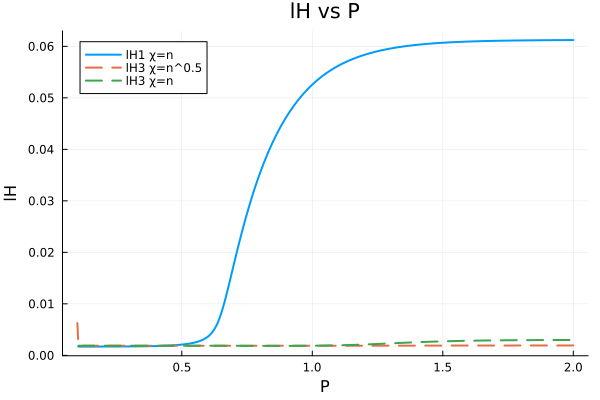

In [187]:
using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3
kappa = 1.0
d = 250
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

alphas = range(0.1, stop=2.0, length=500)
P_values = d .^ collect(alphas)
chi_list = [1.00, n^0.5, n]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

compute_lK_ratio(sol, P) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# VECTORIZED SOLVER
# ---------------------------
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for chi in chi_list
    println("Solving for chi = $chi ...")
    prev_sol = fill(0.1, vars_len)
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for (i,P) in enumerate(P_values)
        f!(F,x) = equations!(F,x,P,chi)
        try
            sol = nlsolve(f!, prev_sol).zero
            sols[i] = is_physical(sol) ? sol : nothing
            prev_sol = sol  # continuation
        catch
            sols[i] = nothing
        end
    end
    results[chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


In [ ]:
# ---------------------------
# PLOTTING
# ---------------------------
# plot(alphas, (lH1_series[1]), label="lH1 χ=1", lw=2)
# plot!(alphas, (lH3_series[1]), label="lH3 χ=1", lw=2, ls=:dash)
plot(alphas, (lH1_series[n]), label="lH1 χ=n", lw=2)
plot!(alphas, (lH3_series[n^0.5]), label="lH3 χ=n^0.5", lw=2, ls=:dash)
plot!(alphas, (lH3_series[n]), label="lH3 χ=n", lw=2, ls=:dash)
xlabel!("P"); ylabel!("lH"); title!("lH vs P")

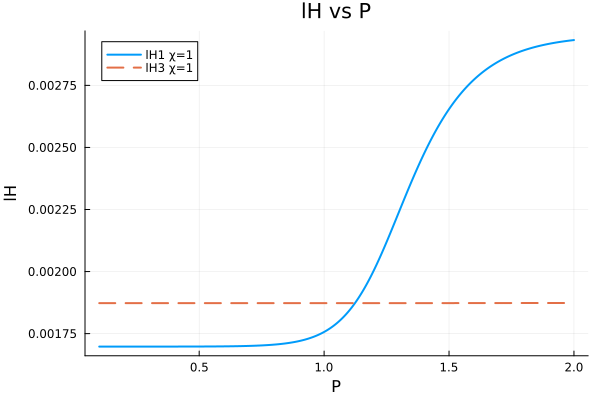

In [186]:
plot(alphas, (lH1_series[1]), label="lH1 χ=1", lw=2)
plot!(alphas, (lH3_series[1]), label="lH3 χ=1", lw=2, ls=:dash)
xlabel!("P"); ylabel!("lH"); title!("lH vs P")

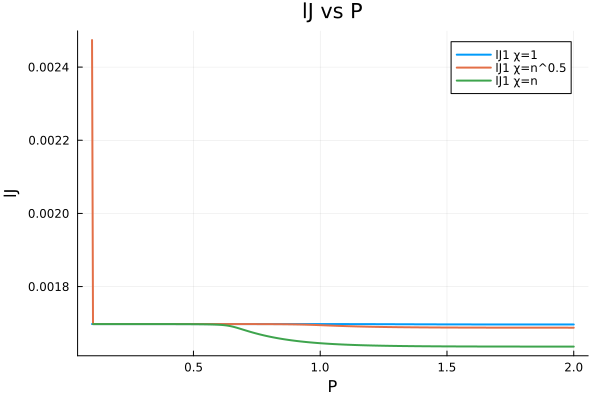

In [185]:

plot(alphas, (lJ1_series[1]), label="lJ1 χ=1", lw=2)
plot!(alphas, (lJ1_series[n^0.5]), label="lJ1 χ=n^0.5", lw=2)

plot!(alphas, (lJ1_series[n]), label="lJ1 χ=n", lw=2)
xlabel!("P"); ylabel!("lJ"); title!("lJ vs P")


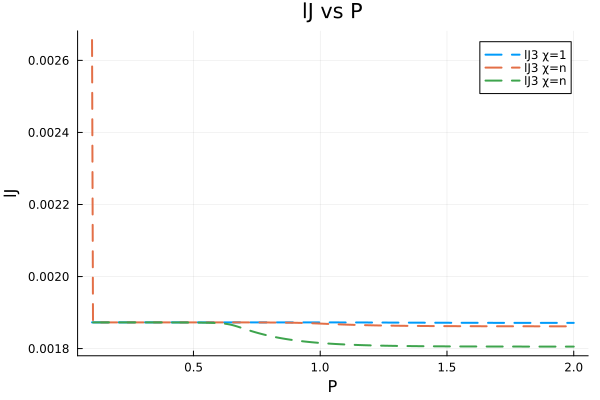

In [182]:

plot(alphas, (lJ3_series[1]), label="lJ3 χ=1", lw=2, ls=:dash)
plot!(alphas, (lJ3_series[n^0.5]), label="lJ3 χ=n", lw=2, ls=:dash)
plot!(alphas, (lJ3_series[n]), label="lJ3 χ=n", lw=2, ls=:dash)
xlabel!("P"); ylabel!("lJ"); title!("lJ vs P")


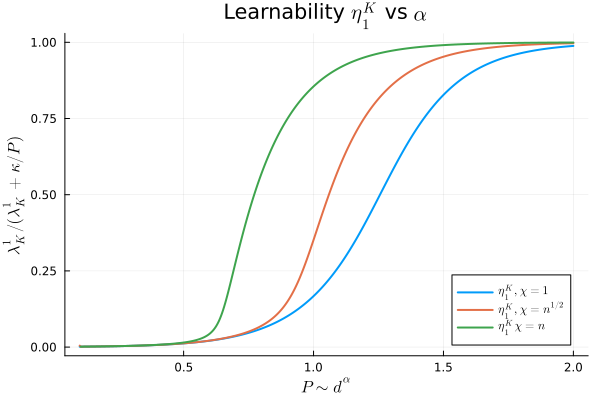

In [179]:
plot(alphas, [r[1] for r in lK_ratio[1]], label=L"\eta^K_1,\chi=1", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L" \eta_ " * " vs " *L" \alpha ")

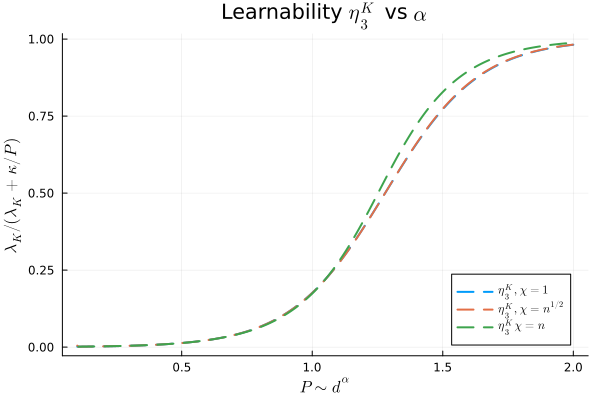

In [180]:
plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")

Solving for n = 10.0 ...
Solving for n = 100.0 ...
Solving for n = 1000.0 ...
Solving for n = 10000.0 ...
Solving for n = 100000.0 ...
Solving for n = 1.0e6 ...
Solving for n = 1.0e7 ...


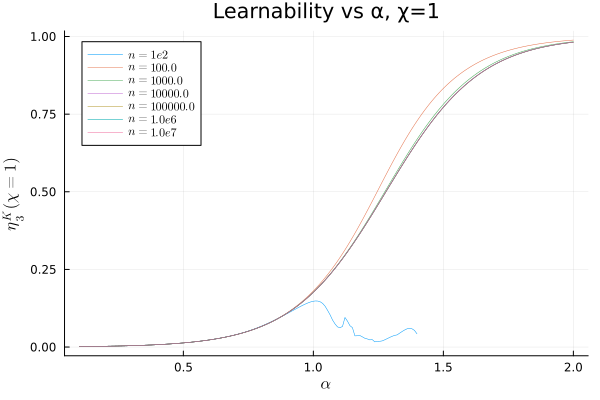

In [210]:
using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n_list = [10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
kappa = 1.0
d = 250
b = 4 / (3 * π)
epsilon = 0.3
delta = 1.0

alphas = range(0.1, stop=2.0, length=200)  # fewer points for speed
P_values_list = [d .^ collect(alphas) for _ in n_list]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

chi_dict = Dict("chi1"=>1.0, "chin"=>nothing)  # chin will be set per n

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, n)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

compute_lK_ratio(sol, P, n) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# SOLVE AND COLLECT RESULTS
# ---------------------------
results_dict = Dict()

for (ni, nval) in enumerate(n_list)
    println("Solving for n = $nval ...")
    P_values = P_values_list[ni]
    chi_dict["chin"] = nval  # chi=n
    results_chi = Dict()
    for (chi_name, chi_val) in chi_dict
        prev_sol = fill(0.1, vars_len)
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        for (i,P) in enumerate(P_values)
            f!(F,x) = equations!(F,x,P,chi_val,nval)
            try
                sol = nlsolve(f!, prev_sol).zero
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            catch
                sols[i] = nothing
            end
        end
        results_chi[chi_name] = sols
    end
    results_dict[nval] = results_chi
end

# ---------------------------
# EXTRACT lK3 RATIOS FOR PLOTTING
# ---------------------------
function extract_lK3(results_dict, n_list, chi_name)
    lK3_ratios = []
    for nval in n_list
        sols = results_dict[nval][chi_name]
        P_values = d .^ collect(alphas)
        push!(lK3_ratios, [compute_lK_ratio(sol,P,nval)[2] for (sol,P) in zip(sols,P_values)])
    end
    return lK3_ratios
end

lK3_chi1 = extract_lK3(results_dict,n_list,"chi1")
lK3_chin = extract_lK3(results_dict,n_list,"chin")

# ---------------------------
# PLOTTING
# ---------------------------
plot(alphas, lK3_chi1[1], label=L"n=1e2", lw=0.5)
for i in 2:length(n_list)
    plot!(alphas, lK3_chi1[i], label=L"n="*L"$"*string(n_list[i])*L"$", lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=1)"); title!("Learnability vs α, χ=1")

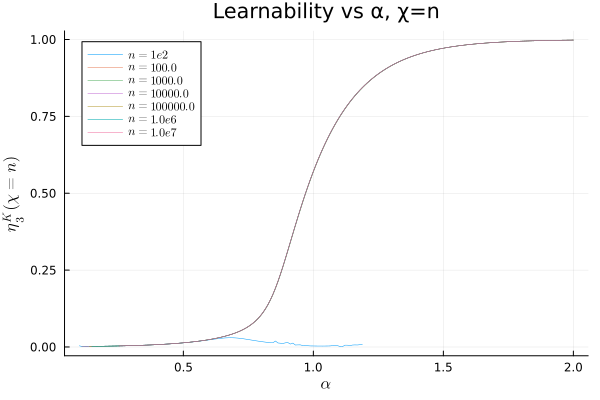

In [211]:

plot(alphas, lK3_chin[1], label=L"n=1e2", lw=0.5)
for i in 2:length(n_list)
    plot!(alphas, lK3_chin[i], label=L"n="*L"$"*string(n_list[i])*L"$", lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n")


In [215]:
using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3            # fixed number of samples
d_list = [50, 100, 250, 500, 1e4, 1e6]  # dimensions to sweep
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

alphas = range(0.1, stop=2.0, length=10000)  # P = d^α
vars_len = 8

chi_dict = Dict("chi1"=>1.0, "chin"=>n)  # chi = 1 or chi = n

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, n, d)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

compute_lK_ratio(sol, P, n, d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# SOLVE OVER d
# ---------------------------
results_dict = Dict()

for dval in d_list
    println("Solving for d = $dval ...")
    P_values = dval .^ collect(alphas)
    results_chi = Dict()
    for (chi_name, chi_val) in chi_dict
        prev_sol = fill(0.1, vars_len)
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        for (i,P) in enumerate(P_values)
            f!(F,x) = equations!(F,x,P,chi_val,n,dval)
            try
                sol = nlsolve(f!, prev_sol).zero
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            catch
                sols[i] = nothing
            end
        end
        results_chi[chi_name] = sols
    end
    results_dict[dval] = results_chi
end

# ---------------------------
# EXTRACT lK3 RATIOS FOR PLOTTING
# ---------------------------
function extract_lK3(results_dict, d_list, chi_name)
    lK3_ratios = []
    for dval in d_list
        sols = results_dict[dval][chi_name]
        P_values = dval .^ collect(alphas)
        push!(lK3_ratios, [compute_lK_ratio(sol,P,n,dval)[2] for (sol,P) in zip(sols,P_values)])
    end
    return lK3_ratios
end

lK3_chi1 = extract_lK3(results_dict,d_list,"chi1")
lK3_chin = extract_lK3(results_dict,d_list,"chin")


Solving for d = 50.0 ...
Solving for d = 100.0 ...
Solving for d = 250.0 ...
Solving for d = 500.0 ...
Solving for d = 10000.0 ...
Solving for d = 1.0e6 ...


6-element Vector{Any}:
 [0.00617072962441628, 0.006175289626196742, 0.006179852976090776, 0.006184419676524235, 0.006188989729924688, 0.006193563138721389, 0.00619813990534533, 0.006202720032229204, 0.006207303521807415, 0.006211890376516087  …  0.9169023594551405, 0.9169601582903253, 0.9170179198292009, 0.9170756440915729, 0.9171333310972424, 0.9171909808660066, 0.9172485934176582, 0.9173061687719863, 0.917363706948776, 0.9174212079678074]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.9626854703007998, 0.9627173503737235, 0.9627492038817931, 0.9627810308459536, 0.962812831287135, 0.962844605226254, 0.9628763526842122, 0.9629080736818971, 0.9629397682401818, 0.9629714363799251]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.8260878538441484, 0.8262679924015117, 0.8264479476064828, 0.8266277196365065, 0.8268073086688849, 0.826986714880777, 0.8271659384491997, 0.8273449795510268, 0.8275238383629893, 0.8277025150616762]
 [NaN, NaN, NaN, 0.0008009911604674214, 0.000801

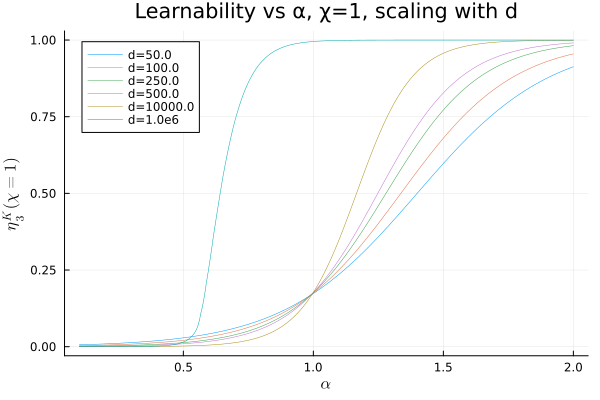

In [216]:

# ---------------------------
# PLOTTING
# ---------------------------
plot(alphas, lK3_chi1[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK3_chi1[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=1)"); title!("Learnability vs α, χ=1, scaling with d")

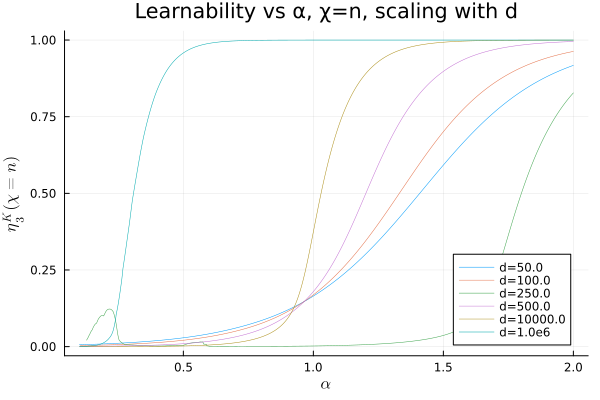

In [218]:

plot(alphas, lK3_chin[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK3_chin[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n, scaling with d")


In [219]:

plot(alphas, lK1_chin[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK1_chin[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n, scaling with d")


LoadError: UndefVarError: `lK1_chin` not defined